# Lab 2: Multimodal Argument Retrieval using FAISS and Graph Neural Networks

## Objectives
This lab is designed to give you hands-on experience in retrieving arguments and discussions from online forums (e.g., Reddit) using a combination of graph-based reasoning and dense text embeddings. The lab is split into two parts:

**Part 1: Building and Analyzing Multimodal Embeddings**

- Extract structured discussion data from Pushshift (a Reddit archive).
- Construct text embeddings using Sentence Transformers.
- Build graph embeddings for discussions using a Graph Neural Network (GNN).
- Visualize embeddings to explore topic clustering and network structures.

**Part 2: Argument Retrieval using FAISS and LangChain**

- Store dense embeddings in FAISS (a scalable vector database).
- Use LangChain to perform Retrieval-Augmented Generation (RAG).
- Perform semantic search on arguments to retrieve contextually relevant discussions.
- Integrate graph-based similarity for better retrieval.

# Load Data
* Use data from: https://www.reddit.com/r/pushshift/comments/1itme1k/separate_dump_files_for_the_top_40k_subreddits/
* Use torrent to download one or more subreddits of your choosing, r/Silksong was chosen for this
* You can use the script in `./scripts/json_to_csv.py` to convert the files to csv if they are downloaded as in JSON format.
* You can use the script in `./scripts/zst_to_csv.py` to convert the files to csv if they are downloaded as ZSTs.

**NOTE:** Remember to run using the GPU

In [6]:
import pandas as pd

# Input comments from a CSV file
input_file = r"..\data\csv\Silksong_comments.csv"

df = pd.read_csv(input_file)
df = df.dropna()
df = df.reset_index()

### Check GPU Usage
**NOTE:** Remember to run using the GPU

In [7]:
import torch

# Check if CUDA-enabled GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Count: {torch.cuda.device_count()}")
else:
    print("GPU is not available. Using CPU.")

Using device: cuda
GPU is available!
GPU Name: NVIDIA GeForce RTX 4070 SUPER
Device Count: 1


# Part 1: Embedding generation

In [8]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sentence_transformers import SentenceTransformer
# from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv
# import subprocess
# import faiss
# import pickle

# df = pd.read_csv(input_file)
# df = df.dropna()
# df = df.reset_index()

In [9]:
from sentence_transformers import SentenceTransformer

# Compute Similarity Edges
print("Computing embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
embeddings = model.encode(df['body'], convert_to_tensor=True)

# Print embedding vector total and dimension
print(f"Embedding total vectors: {embeddings.shape[0]}")
print(f"Embedding vector dimension: {embeddings.shape[1]}")

computing embeddings
Embedding total vectors: 514550
Embedding vector dimension: 384


In [10]:
import numpy as np

# Convert embeddings to numpy (FAISS requires float32)
print("Converting to numpy..")
embeddings_np = embeddings.cpu().numpy().astype('float32')
np.save("..\data\processed\Silksong_comments_embeddings.npy", embeddings_np)

Converting to numpy..


In [12]:
import faiss

# Create FAISS index for similarity search
print("Creating FAISS index...")
index = faiss.IndexFlatIP(embeddings_np.shape[1])  # Inner product (cosine similarity)
index.add(embeddings_np)

Creating FAISS index...


In [13]:
# Save the FAISS index to a file
faiss.write_index(index, "..\data\processed\Silksong_comments_faiss.index")
print("FAISS index saved successfully.")

FAISS index saved successfully.


In [14]:
# Perform a search for the top 10 most similar posts for each post
k = 10  # Number of nearest neighbors to retrieve
D, I = index.search(embeddings_np, k)

In [16]:
import networkx as nx

print("NetworkX version: " + nx.__version__)

# Store results in a DataFrame and build the graph
print("computing similarity")
similarity_results = []
G = nx.Graph()

NetworkX version: 3.4.2
computing similarity


In [17]:
for i in range(len(df)):
    post_id = df.iloc[i]['index']
    G.add_node(post_id, text=df.iloc[i]['body'])
    similar_posts = []
    for j in range(1, k):  # Exclude self-match
        similar_post_id = df.iloc[I[i, j]]['index']
        similarity_score = D[i, j]
        similar_posts.append((similar_post_id, similarity_score))
        G.add_edge(post_id, similar_post_id, weight=similarity_score)
    similarity_results.append({"post_id": post_id, "similar_posts": similar_posts})

# Summarize structure of graph
print("Graph summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Graph summary:
Number of nodes: 514550
Number of edges: 3926830


In [18]:
import pickle

# save the graph
pickle.dump(G, open("..\data\processed\Silksong_comments_graph.pickle", 'wb'))
similarity_df = pd.DataFrame(similarity_results)

# Save this in case that you need to do recomputation
similarity_df.to_json("..\data\processed\Silksong_comments_faiss_similar_posts.json", orient="records", lines=True)
print("saved similarity results")

saved similarity results


In [19]:
# Visualize Graph Structure
# plt.figure(figsize=(10, 6))
# nx.draw(G, with_labels=False, node_size=20)
# plt.title("Graph Structure of Subreddit")
# plt.savefig('./figures/graph_structure.png', dpi=300, bbox_inches='tight')
# plt.show()

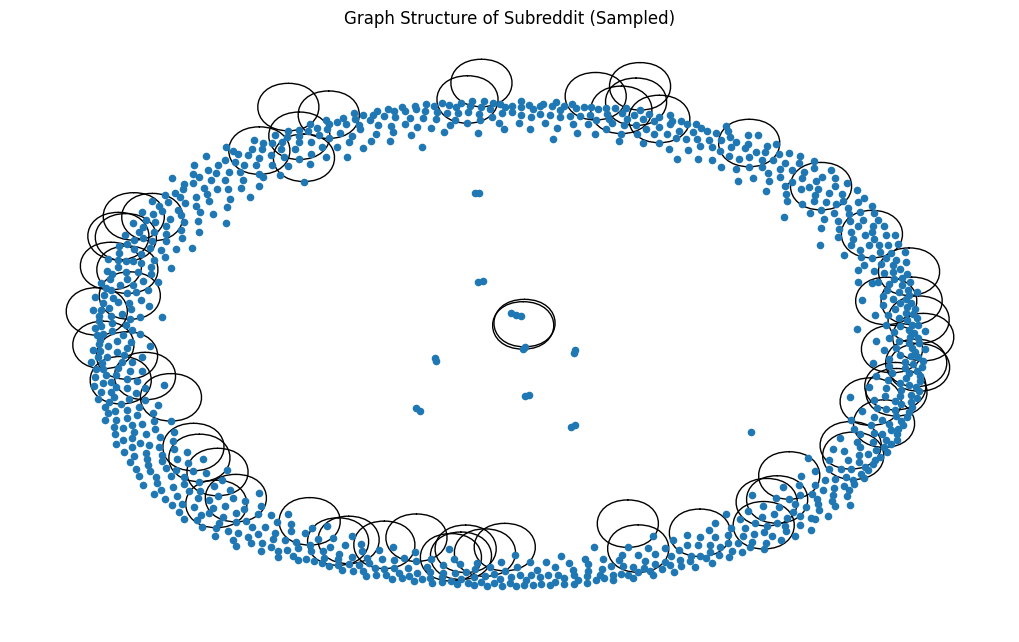

In [ ]:
import random
import matplotlib.pyplot as plt

# Sample and visualize the graph structure
sample_size = 1000  # For example, use 1,000 nodes

# Sample nodes from the graph (if the graph is larger than sample_size)
if len(G.nodes()) > sample_size:
    sampled_nodes = random.sample(list(G.nodes()), sample_size)
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

plt.figure(figsize=(10, 6))
nx.draw(G_sub, with_labels=False, node_size=20)
plt.title("Graph Structure of Subreddit (1000 Random Samples)")
plt.savefig('./figures/graph_structure_sampled.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Identify the largest connected component
# largest_cc = max(nx.connected_components(G), key=len)
# G_lcc = G.subgraph(largest_cc)

# plt.figure(figsize=(10, 6))
# nx.draw(G_lcc, with_labels=False, node_size=20)
# plt.title("Graph Structure of Subreddit (Largest Connected Component)")
# plt.savefig('./figures/graph_structure_lcc.png', dpi=300, bbox_inches='tight')
# plt.show()

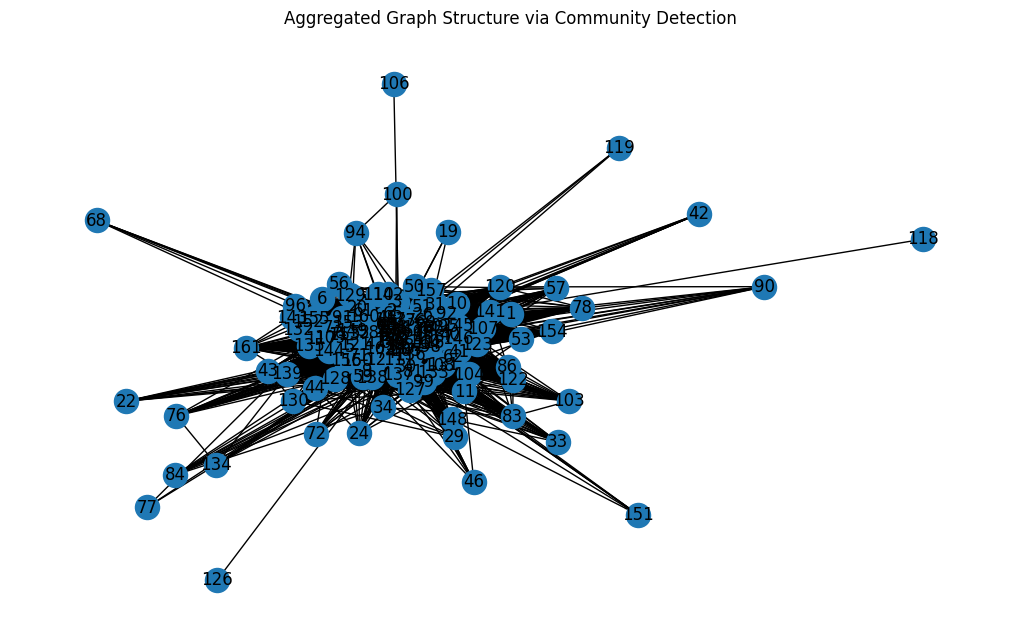

In [24]:
import community as community_louvain  # Requires the python-louvain package

# Compute communities (each node will be assigned a community label)
partition = community_louvain.best_partition(G)

# Create a new graph where each node is a community and edge weights reflect inter-community connections.
aggregated_edges = {}
for node1, node2 in G.edges():
    comm1 = partition[node1]
    comm2 = partition[node2]
    if comm1 != comm2:
        aggregated_edges[(comm1, comm2)] = aggregated_edges.get((comm1, comm2), 0) + 1

# Construct the community graph
G_comm = nx.Graph()
for (comm1, comm2), weight in aggregated_edges.items():
    G_comm.add_edge(comm1, comm2, weight=weight)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_comm)
nx.draw(G_comm, pos, with_labels=True, node_size=300)
plt.title("Aggregated Graph Structure via Community Detection")
plt.savefig('./figures/graph_structure_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
import multiprocessing

n_jobs = max(1, multiprocessing.cpu_count() - 2)
print(f"Number of CPU cores available: {n_jobs}")

Number of CPU cores available: 30


In [27]:
# Convert embeddings from CUDA tensor to a NumPy array on the CPU
embeddings_np = embeddings.cpu().numpy()

In [28]:
from sklearn.manifold import TSNE

# Perform t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=n_jobs, verbose=0)
emb_2d = tsne.fit_transform(embeddings_np)

# Save the 2D embeddings as a pickle file
with open("..\data\processed\Silksong_comments_embeddings_2d.pkl", 'wb') as f:
    pickle.dump(emb_2d, f)
print("t-SNE embeddings saved successfully.")

c:\Users\cjsta\miniconda3\envs\st_gnn_reddit\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


t-SNE embeddings saved successfully.


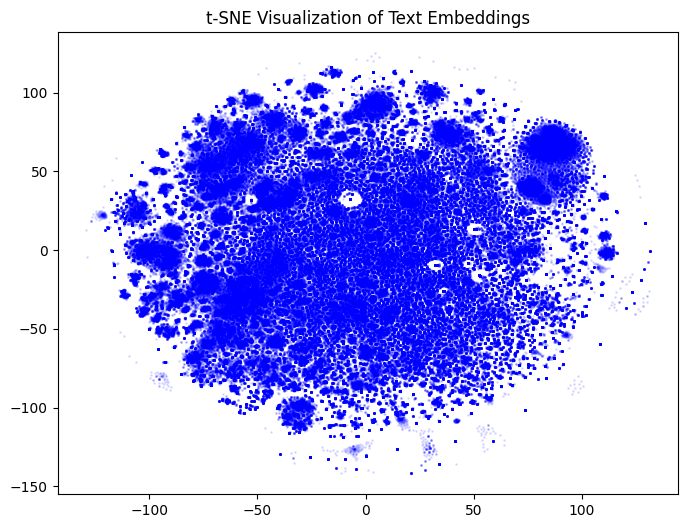

In [29]:
# Plot the t-SNE results with adjusted point size and increased transparency
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], alpha=0.1, c='blue', s=1)  # Adjust 'alpha' for transparency, 's' for marker size
plt.title("t-SNE Visualization of Text Embeddings")
plt.savefig('./figures/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


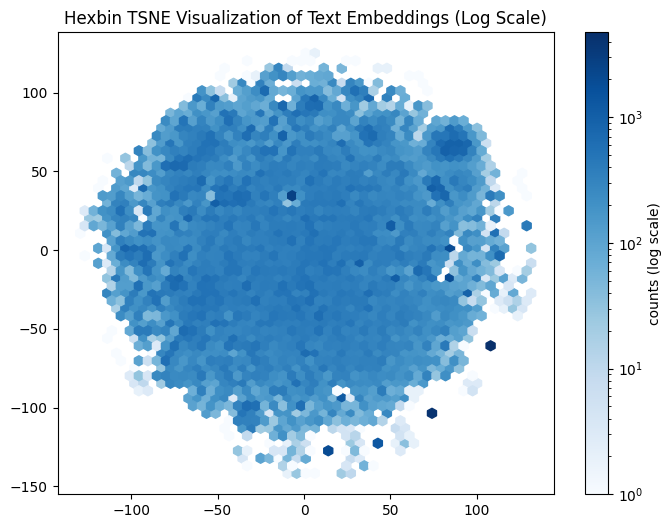

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    emb_2d[:, 0],
    emb_2d[:, 1],
    gridsize=50,
    cmap='Blues',
    mincnt=1,
    norm=LogNorm()  # Apply logarithmic normalization to the color scale
)
plt.colorbar(hb, label='counts (log scale)')
plt.title("Hexbin TSNE Visualization of Text Embeddings (Log Scale)")
plt.savefig('./figures/tsne_visualization_hexbin_log.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import json
# import faiss
# import pandas as pd
# from sentence_transformers import SentenceTransformer
# from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv
# import subprocess
# import pickle

# G = pickle.load(open('/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/graph.pickle', 'rb'))
# embeddings_np = np.load("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/embeddings.npy")

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Define GNN Model for Node Embeddings
class GNN(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=384):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

def train(model, data, epochs=20):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.x)  # Unsupervised training
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return out

In [34]:
from torch_geometric.data import Data

# Convert Graph to PyTorch Geometric Data Format
node_mapping = {node: i for i, node in enumerate(G.nodes())}
edges = np.array([(node_mapping[u], node_mapping[v]) for u, v in G.edges()])
x = torch.tensor(embeddings_np, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

In [36]:
# Train GNN Model
model = GNN(input_dim=384, hidden_dim=128, output_dim=384)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print("Node feature matrix shape:", data.x.shape)  # Should be (num_nodes, feature_dim)

NameError: name 'GCNConv' is not defined

In [ ]:
# Train and obtain new node embeddings
node_embeddings = train(model, data)
torch.save(model.state_dict(), "../data/processed/Silksong_comments_gnn_embeddings.pt")

In [ ]:
# Convert embeddings to numpy (FAISS requires float32)
print("converting to numpy")
node_embeddings_np = node_embeddings.cpu().detach().numpy().astype('float32')
np.save("../data/processed/Silksong_comments_node_embeddings.npy", node_embeddings_np)

# Node embeddings size
print(f"Node embeddings total vectors: {node_embeddings_np.shape[0]}")
print(f"Node embeddings vector dimension: {node_embeddings_np.shape[1]}")

In [ ]:
# Compute Node Embeddings using t-SNE
node_emb_2d = tsne.fit_transform(node_embeddings)


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], alpha=0.7, c='red')
plt.title("t-SNE Visualization of GNN-based Node Embeddings")
plt.savefig('./figures/tsne_visualization_gnn_node_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

# Part 2: Retrieval Augmented Generation

In [ ]:
# !pip install -U langchain-community

In [ ]:

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document


In [ ]:
# Load FAISS index
embedding_dim = index.d # get the embedding dimension from faiss
assert embeddings_np.shape[1] == embedding_dim, "Embedding dimension mismatch"

In [ ]:
# Create FAISS-based retriever
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS(embeddings, index, {})
retriever = vectorstore.as_retriever()

In [ ]:
# Set up LLM-based QA system
llm = ChatOpenAI(model_name="gpt-4")
qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever)

In [ ]:
# Example query
query = "What are the key arguments in favor and against tariffs?"
response = qa_chain.run(query)
print("Response:", response)


# Lab Steps

From the following 4 points, chose at least 2 of them and implement the suggested improvements. Note that you can also select and implement your own improvements to the lab. The goal is for you to gain some practical experience dealing with multimodal embeddings and/or RAG


## **1. Improve Graph Embeddings with Random Walks (Node2Vec)**
Instead of relying solely on a GCN-based approach, implement **Node2Vec**, a random walk-based technique for generating graph embeddings. This approach captures **structural properties** of the graph.

### **Steps to use Node2Vec to generate graph gmbeddings:**
   - Install `torch_geometric` extensions:  
     ```bash
     pip install torch-geometric torch-sparse torch-scatter
     ```
   - Modify the code to use **Node2Vec**:
     ```python

     # Define Node2Vec model - example
     node2vec = Node2Vec(edge_index, embedding_dim=128, walk_length=10, context_size=5, walks_per_node=10, num_negative_samples=1, sparse=True)
    ```
   - Train the model
    
   - Produce node embeddings

   - Visualize embeddings and compare visualizations

---

## **2. Combine Graph and Text Embeddings into a Multimodal Representation**
Instead of treating text and graph separately, merge them into a **joint embedding space**.

### **Methods to Combine Graph and Text Embeddings**
#### **A. Concatenation**
Combine graph embeddings (`node2vec`) with sentence embeddings (`SentenceTransformer`):
```python
combined_embeddings = torch.cat((text_embeddings, node_embeddings), dim=1)
```

#### **B. Attention-Based Fusion**
Use a **Transformer-based attention mechanism** to weigh the importance of text vs. graph (example):
```python
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNNWithAttention(nn.Module):
    def __init__(self, text_dim, graph_dim, hidden_dim):
        super(GNNWithAttention, self).__init__()
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.graph_fc = nn.Linear(graph_dim, hidden_dim)
        self.gat = GATConv(hidden_dim, hidden_dim, heads=4)

    def forward(self, text_emb, graph_emb, edge_index):
        text_hidden = F.relu(self.text_fc(text_emb))
        graph_hidden = F.relu(self.graph_fc(graph_emb))
        combined = text_hidden + graph_hidden  # Attention could be applied here
        out = self.gat(combined, edge_index)
        return out
```

---

## **3. Improve Text Processing with Context-Aware Models**
Instead of using `all-MiniLM-L6-v2`, experiment with:
- **Long-form debate models**: `mistral-7b-instruct`  
- **Graph-aware NLP models**: `GraphFormers`

---

## **4. Experiment with Different RAG Retrieval Strategies**
Once embeddings are improved, test different retrieval techniques:
- **Graph-based retrieval**: Use **random walk proximity** to rank arguments.
- **Hybrid search**: Combine **FAISS (vector search)** with **Graph Traversal**.
- **Context re-ranking**: Use **Cross-Encoder BERT** models to improve final ranking.

---

### **Deliverables**

* Notebook with code and explanations.
* Report summarizing findings and insights, include visualizations comparing model predictions.
